In [1]:
import pandas as pd

master_training_df = pd.read_csv('../data/master_training_data.csv')

print("Historical training data loaded successfully!")
master_training_df.head()

Historical training data loaded successfully!


,id_x,status,chance_of_playing_next_round,chance_of_playing_this_round,now_cost,now_cost_rank,now_cost_rank_type,cost_change_event,cost_change_event_fall,cost_change_start,...,gw,set_piece_threat,web_name,position,team_code,team_id,team_name,team_elo,opponent_elo,is_home
0,607,a,NaN,NaN,5.0,285,184,0,0,0,...,1,0.000000,O’Reilly,Midfielder,43,13,Man City,1958,1790.56,True
1,1,d,75.0,75.0,5.5,147,91,0,0,0,...,1,6.666667,Fábio Vieira,Midfielder,3,1,Arsenal,1991,1716.28,True
2,2,a,NaN,NaN,7.0,30,13,0,0,0,...,1,0.000000,G.Jesus,Forward,3,1,Arsenal,1991,1716.28,True
3,3,a,NaN,NaN,6.0,83,6,0,0,0,...,1,0.000000,Gabriel,Defender,3,1,Arsenal,1991,1716.28,True
4,4,a,NaN,NaN,8.0,12,4,0,0,0,...,1,13.333333,Havertz,Forward,3,1,Arsenal,1991,1716.28,True


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

# --- Step 1: Define Your Features (X) and Target (y) ---
target = 'event_points'
features = [
    'now_cost', 'selected_by_percent', 'form', 'total_points', 'bonus', 'bps',
    'expected_goals_per_90', 'expected_assists_per_90', 'expected_goal_involvements_per_90',
    'expected_goals_conceded_per_90', 'influence', 'creativity', 'threat', 'ict_index',
    'team_elo', 'opponent_elo', 'is_home'
]
model_df = master_training_df.dropna(subset=features + [target])

# *** FIX: Convert the boolean 'is_home' column to integers (1s and 0s) ***
model_df['is_home'] = model_df['is_home'].astype(int)

X = model_df[features]
y = model_df[target]

# --- Step 2: Split the Data ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Step 3: Train the Model ---
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)
print("Model training complete!")

# --- Step 4: Evaluate the Model ---
predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
print(f"\nModel Evaluation:")
print(f"The model's predictions are off by an average of {mae:.2f} points.")

Model training complete!

Model Evaluation:
The model's predictions are off by an average of 0.78 points.


/var/folders/dk/62dh8_zj4z71lq26wx5z5_m80000gn/T/ipykernel_54845/1520584803.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['is_home'] = model_df['is_home'].astype(int)


In [3]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# We already have our 'predictions' and the actual values 'y_test' from the previous cell

# --- Calculate RMSE ---
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print(f"RMSE (Root Mean Squared Error): {rmse:.2f} points")

# --- Calculate R-Squared ---
r2 = r2_score(y_test, predictions)
print(f"R-Squared: {r2:.2f}")
print(f"(This means our model explains {r2:.1%} of the variance in player points)")

RMSE (Root Mean Squared Error): 1.63 points
R-Squared: 0.51
(This means our model explains 51.2% of the variance in player points)


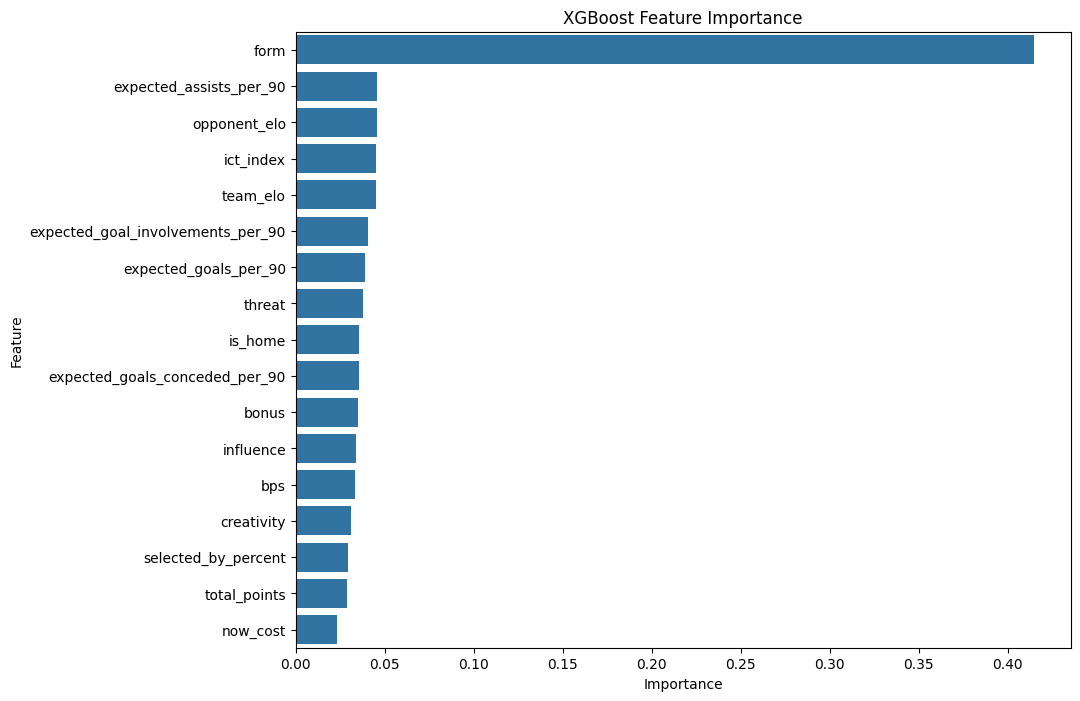

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame of feature importances
feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()